# aSPEM Experiment : analysis




In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import division, print_function, absolute_import
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import os
if not os.path.exists('figures/Result'):
    os.makedirs('figures/Result')

In [3]:
t_titre = 35
t_label = 25
fig_width= 15
exts = ['.png', '.svg', '.pdf']
dpi = 400

In [4]:
observer = None #'AM'
mode = 'pari'

from aSPEM import Analysis
e = Analysis(observer=observer, mode=mode, name_file_fit='fct_velocity_sigmo')

In [5]:
opt = {'t_titre':80, 't_label':60, 'titre':'', 'color_r':'r'}

proba = 'real', 'bcp'

mode_bcp = 'fixed', 'max', 'expectation', 'mean'

result = 'bet', 'acceleration', 'velocity'

In [6]:
import numpy as np

In [7]:
def mutual_information(hgram):
    pxy = hgram / float(np.sum(hgram))
    px = np.sum(pxy, axis=1)
    py = np.sum(pxy, axis=0)
    px_py = px[:, None] * py[None, :]
    nzs = pxy > 0
    return np.sum(pxy[nzs] * np.log(pxy[nzs] / px_py[nzs]))


def regress(ax, p, data, y1, y2, t_label,color='k', x1=-0.032, x2=1.032, pos='right') :
    from scipy import stats
    slope, intercept, r_, p_value, std_err = stats.linregress(p, data)
    x_test = np.linspace(np.min(p), np.max(p), 100)
    fitLine = slope * x_test + intercept
    ax.plot(x_test, fitLine, c=color, linewidth=2)
    
    if pos=='right' : x_pos=x2-(x2-x1)/10
    else:             x_pos=x1+(x2-x1)/10
    
    ax.text(x_pos,y1+(y2-y1)/10, 'r = %0.3f'%(r_), color=color, fontsize=t_label/1.2, ha=pos)

    hist, x_edges, y_edges = np.histogram2d(p, data ,bins=20)
    ax.text(x_pos,y1+2*(y2-y1)/10, 'MI = %0.3f'%(mutual_information(hist)), color=color,
            fontsize=t_label/1.2, ha=pos)

    return ax


In [8]:
def comparison(ax=None, proba='bcp', result='bet', mode_bcp='mean', show='kde', mean_kde=True,
                nb_point_kde=300j, cmap='Greys', alpha=1, hatches=None, levels=5, vmax=0.5, pos='right',
                t_titre=35, t_label=25, titre=None, pause=True, color_r='r', fig=None, fig_width=15) :

    if fig is not None:
        import matplotlib.pyplot as plt
        fig, ax = plt.subplots(1, 1, figsize=(fig_width, fig_width))

    subjects = ['AM','BMC','CS','DC','FM','IP','LB','OP','RS','SR','TN']#,'YK']
    nb_sujet = len(subjects)
    full = e.Full_list(modes_bcp=mode_bcp, pause=pause)


    ax.set_xlabel('$\hat{P}_{%s}$'%(mode_bcp), fontsize=t_label/1)
    proba = 'p_hat_'+mode_bcp
    full_proba = full[proba]

    xmin, xmax = -0.032, 1.032

    if result=='velocity' :
        res, ymin, ymax = 'va', -10.64, 10.64
        ax.set_ylabel('Velocity of anticipation (°/s)', fontsize=t_label/1.2)
        if titre is None : ax.set_title("Velocity", fontsize=t_titre/1.2, x=0.5, y=1.05)

    full_result = full[res]

    # masque les essais qui où full_result = NAN
    proba = np.ma.masked_array(full_proba.values.tolist(), mask=np.isnan(full_result.values.tolist())).compressed()
    data = np.ma.masked_array(full_result.values.tolist(), mask=np.isnan(full_result.values.tolist())).compressed()

    from matplotlib import cm
    if show=='kde':
        from scipy import stats

        values = np.vstack([proba, data])
        kernel = stats.gaussian_kde(values)
        xx, yy = np.mgrid[xmin:xmax:nb_point_kde, ymin:ymax:nb_point_kde]
        positions = np.vstack([xx.ravel(), yy.ravel()])
        f = np.reshape(kernel(positions).T, xx.shape)

        fmean = f / f.sum(axis=1)[:, np.newaxis]
        
        
        if type(levels)==int : level=np.arrange(len(levels))
        level = [(round(float(x[:-1])*np.max(fmean)/100, 4) if x[-1]=='%'
             else round(float(x)*np.max(fmean), 4)) if type(x)==str
             else x for x in levels]

        
        if hatches is None : hatches = [None, '/', '/////', '///////////////////////////////////']
        
        import matplotlib as mpl
        mpl.rcParams['hatch.linewidth'] = 1.5
        mpl.rcParams['hatch.color'] = mpl.colors.to_rgba(cmap, alpha=0.7)
        
        
        A = ax.contourf(xx, yy, fmean, levels=level, hatches=hatches, colors='none')
        ax.contour(xx, yy, fmean, levels=level, colors=cmap, alpha=0.7)
        
        artists = A.legend_elements()[0]

        l = ['%s (%s) < $f_{mean}$ $\\leq$ %s (%s)'%(levels[x], level[x], levels[x+1], level[x+1])
             if type(levels[x])==str
             else '%s < $f_{mean}$ $\\leq$ %s'%(level[x], level[x+1])
             
             for x in range(len(level)-1)]
        legend = ax.legend(artists, l, loc='upper %s'%pos, fontsize=16, frameon=False,
                           title='$\hat{P}_{%s}$'%mode_bcp,title_fontsize=20)

        ax.add_artist(legend)

    ax = regress(ax, proba, data, ymin, ymax, t_label, color=color_r, pos=pos)

    ax.axis([xmin, xmax, ymin, ymax])

    ax.tick_params(labelsize=t_label/1.8, bottom=True, left=True)
    #------------------------------------------------

    
    
    
    return ax

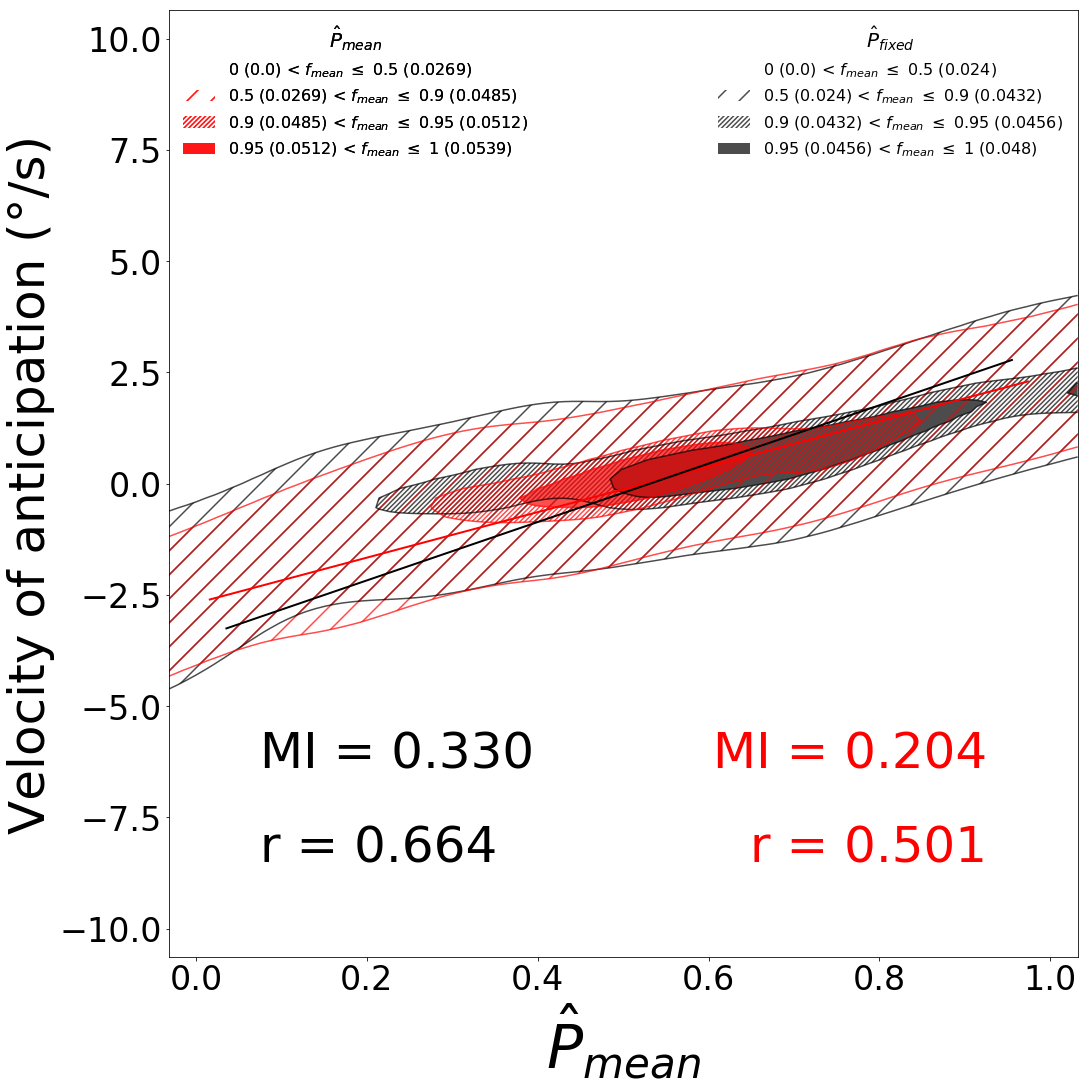

In [9]:
fig, axs = plt.subplots(1, 1, figsize=(15, 15),constrained_layout=True)
levels = ['0%', '50%', '90%', '95%', '100%']
levels = ['0', '0.5', '0.9', '0.95', '1']

opt['color_r'] = 'r'
axs = comparison(ax=axs, result='velocity', mode_bcp='fixed', vmax=1, 
                   show='kde', cmap='k', alpha=1, levels=levels,
                   nb_point_kde=100j,  pos='right', **opt)


opt['color_r'] = 'k'
axs = comparison(ax=axs, result='velocity', show='kde', levels=levels, vmax=0.9, 
                   nb_point_kde=100j, cmap='r', alpha=1, pos='left', **opt)

#fig.tight_layout()

#for ext in exts: fig.savefig('ms/figures/4_A_result_psycho_velo_sigmo' + ext, dpi=dpi)

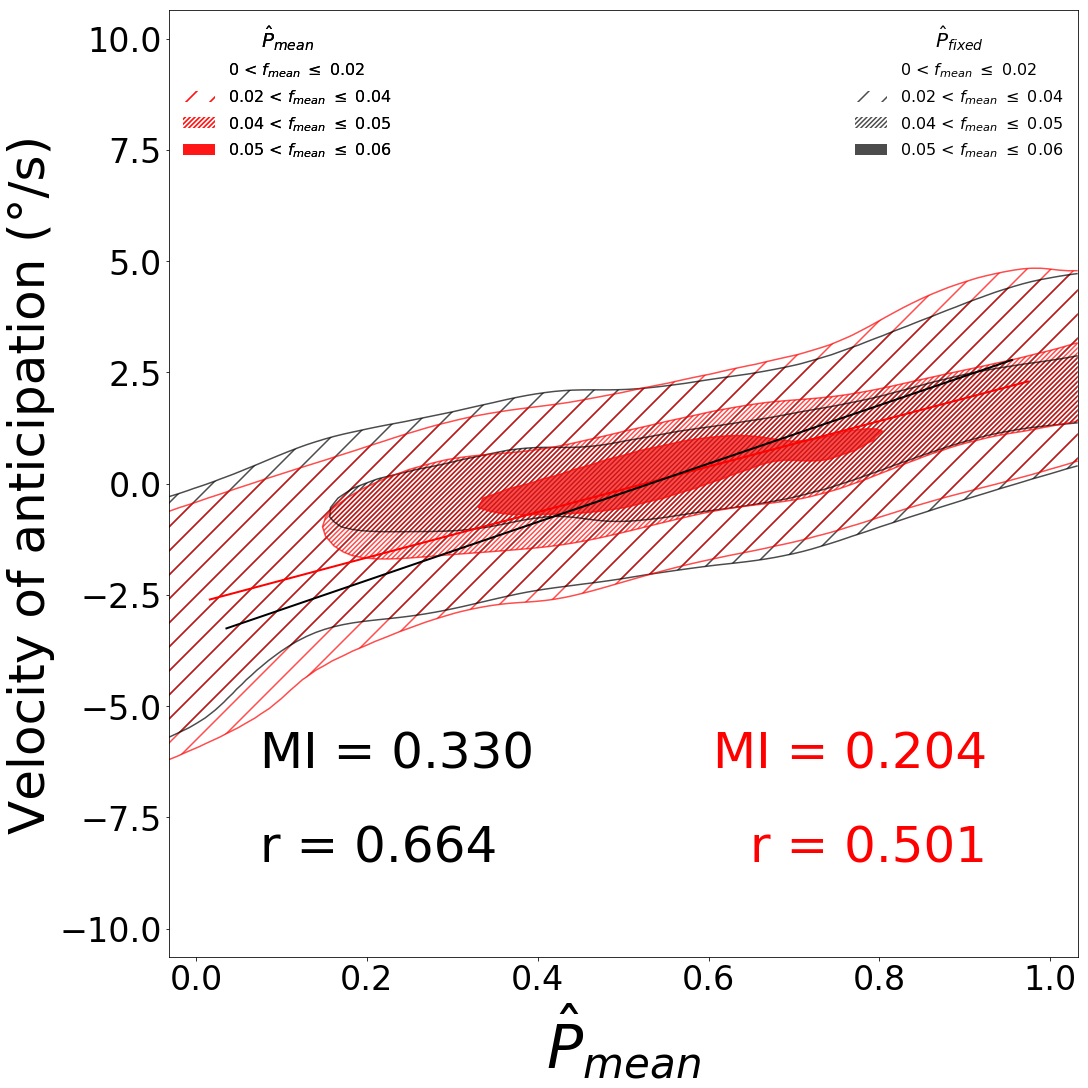

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(15, 15),constrained_layout=True)
levels = [0, 0.02, 0.04, 0.05, 0.06]

opt['color_r'] = 'r'
axs = comparison(ax=axs, result='velocity', mode_bcp='fixed', vmax=1, 
                   show='kde', cmap='k', alpha=1, levels=levels,
                   nb_point_kde=100j,  pos='right', **opt)


opt['color_r'] = 'k'
axs = comparison(ax=axs, result='velocity', show='kde', levels=levels, vmax=0.9, 
                   nb_point_kde=100j, cmap='r', alpha=1, pos='left', **opt)

#fig.tight_layout()

#for ext in exts: fig.savefig('ms/figures/4_A_result_psycho_velo_sigmo' + ext, dpi=dpi)

In [152]:
axs.legend()

No handles with labels found to put in legend.


In [ ]:
axs.contourf()

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'N'
  s)
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


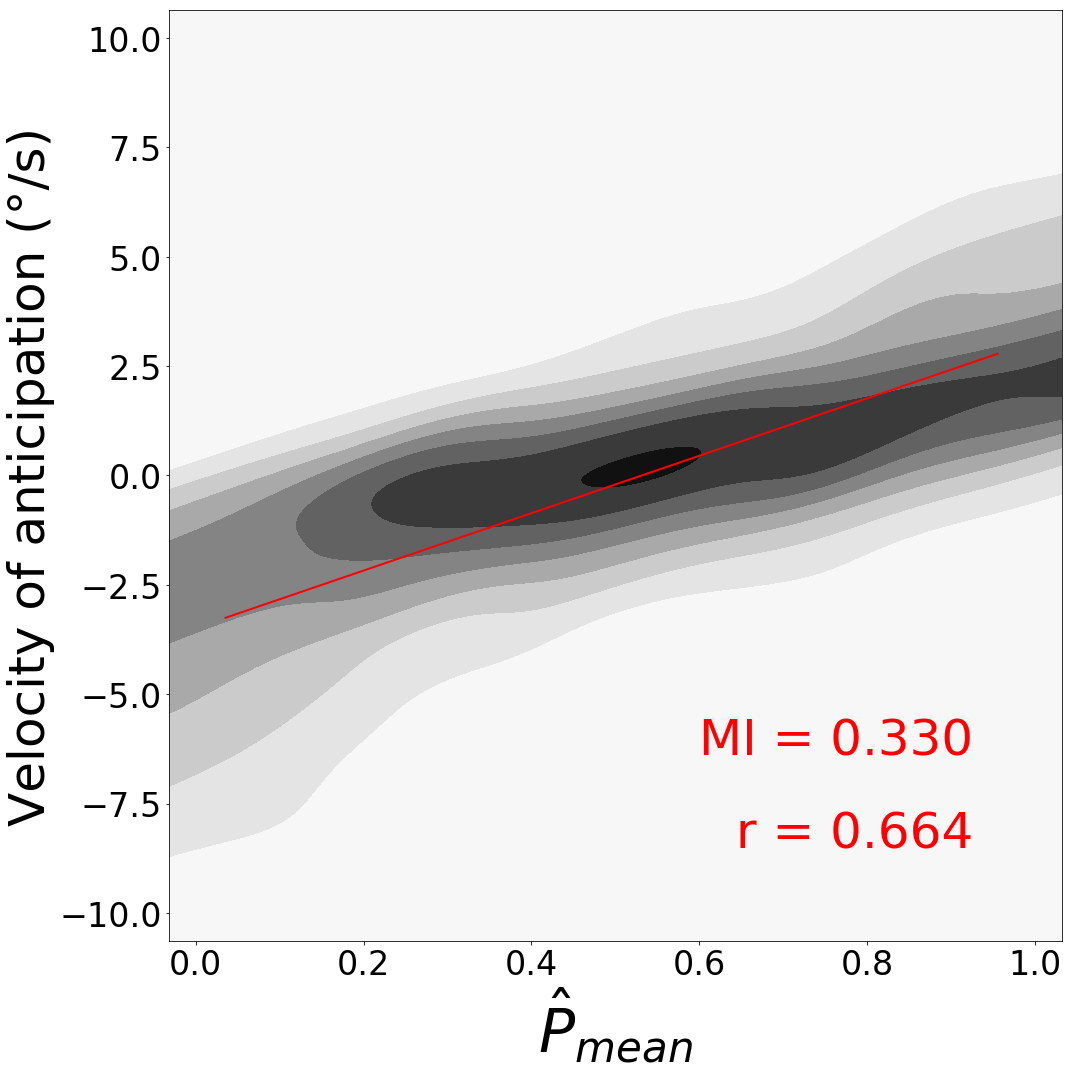

In [8]:
fig, axs = plt.subplots(1, 1, figsize=(fig_width, fig_width),constrained_layout=True)
axs = e.comparison(ax=axs, result='velocity', show='kde',
                   nb_point_kde=300j, **opt)
fig.tight_layout()
#for ext in exts: fig.savefig('ms/figures/4_A_result_psycho_velo_sigmo' + ext, dpi=dpi)

/usr/local/lib/python3.5/dist-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'N'
  s)
/usr/local/lib/python3.5/dist-packages/matplotlib/figure.py:2144: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  warnings.warn("This figure was using constrained_layout==True, "


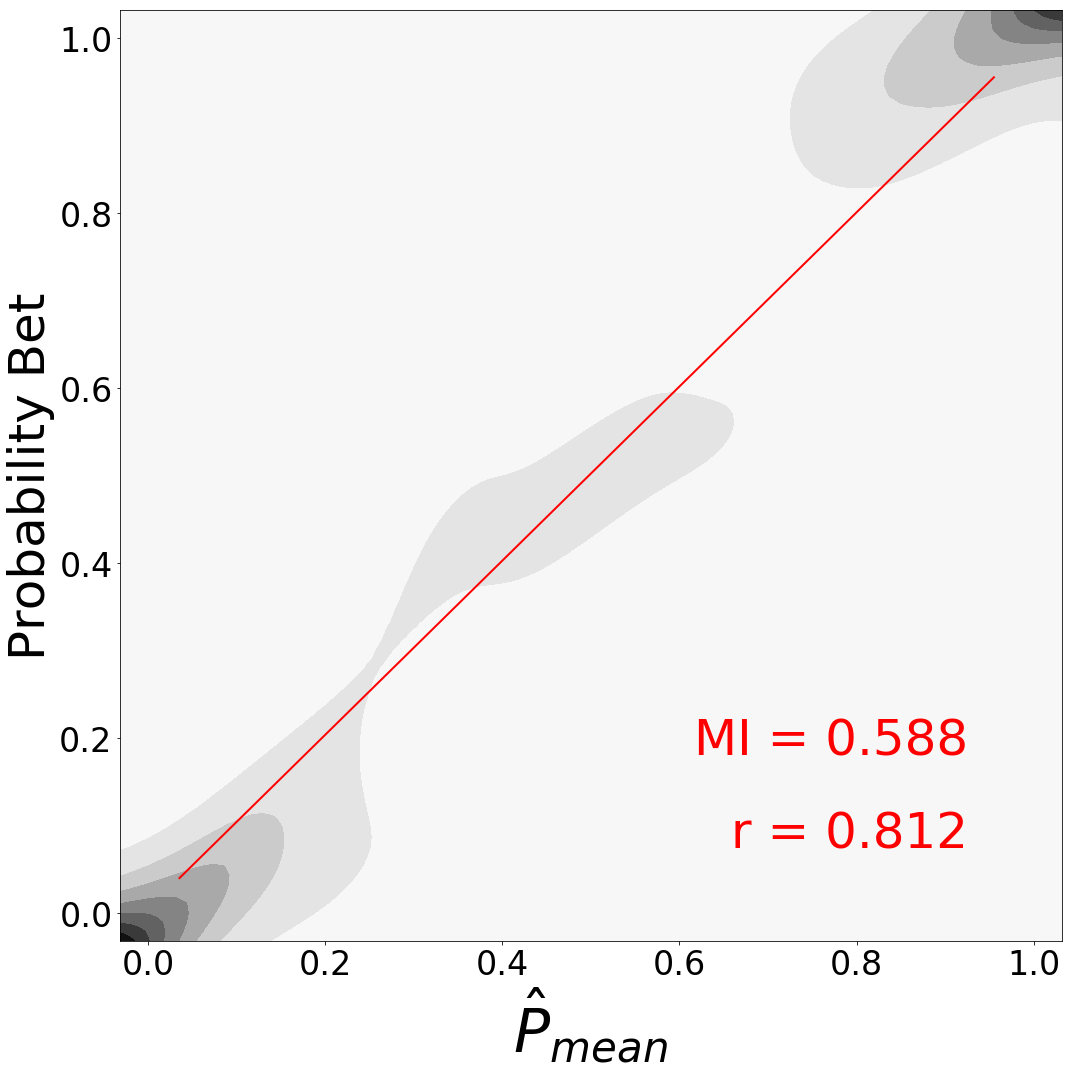

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(fig_width, fig_width), constrained_layout=True)
axs = e.comparison(ax=axs, nb_point_kde=100j,  **opt)
fig.tight_layout()
#for ext in exts: fig.savefig('ms/figures/4_B_result_psycho_bet' + ext, dpi=dpi)

In [ ]:
axs.contourf()

scatterKDE


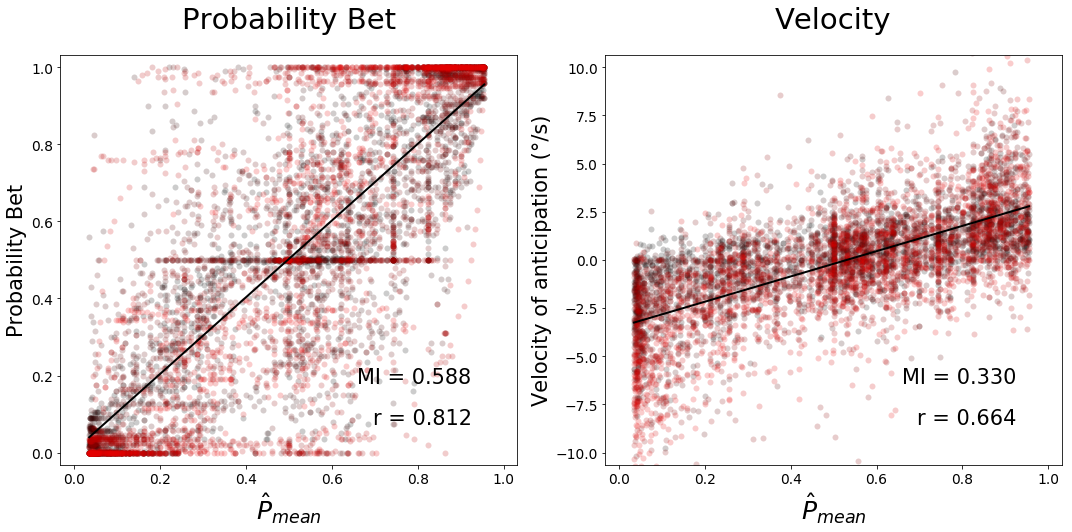

scatterKDE


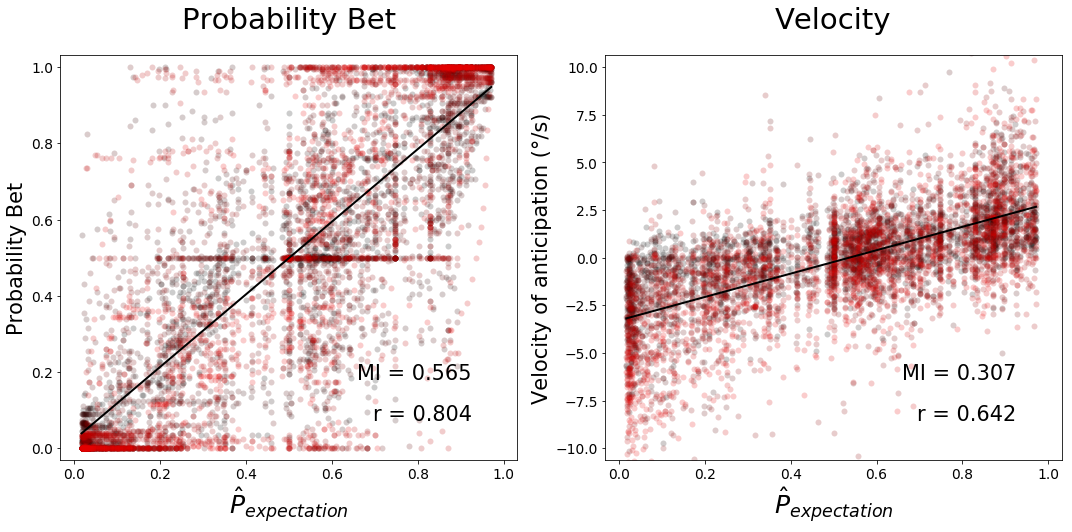

scatterKDE


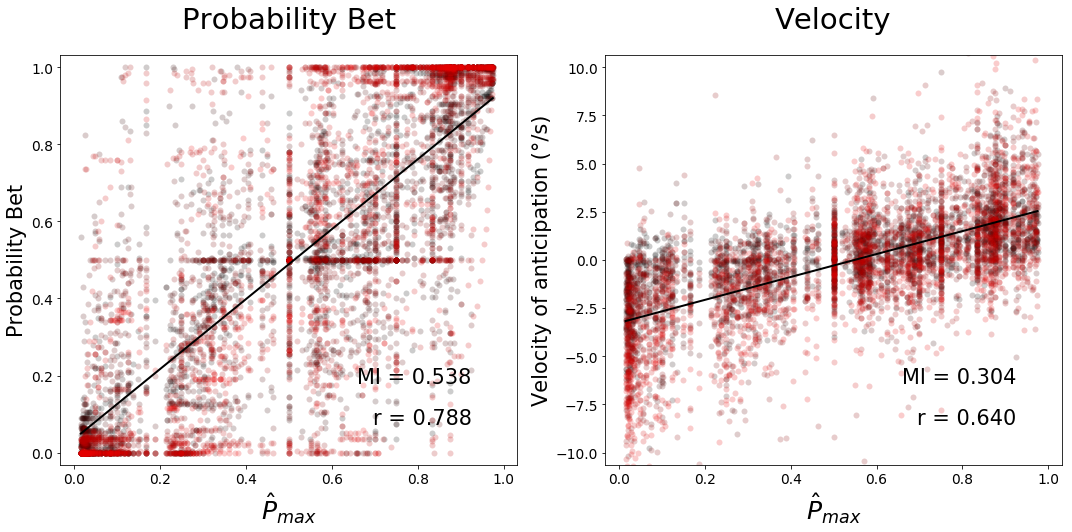

scatterKDE


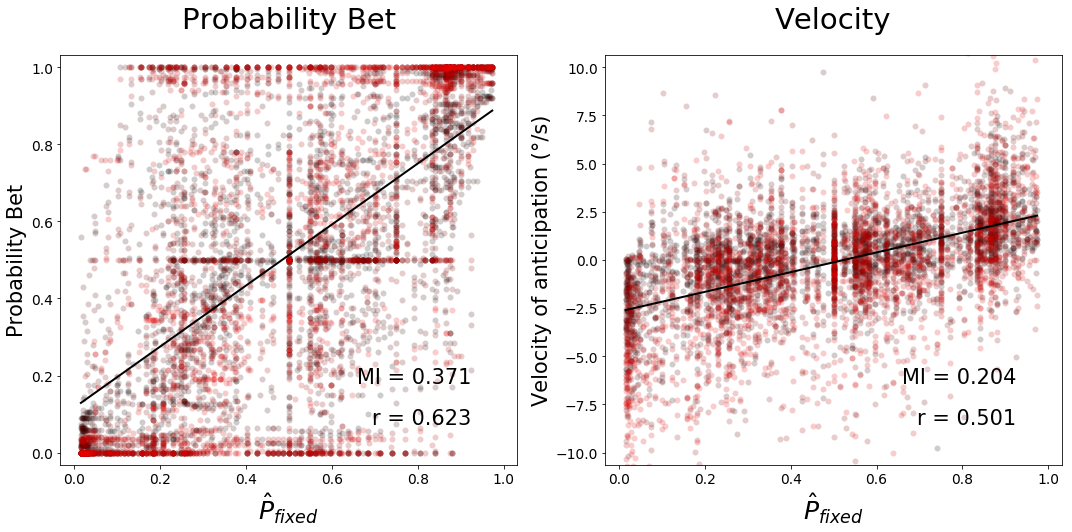

In [8]:
for mode in ['mean', 'expectation', 'max', 'fixed']:
    fig, ax = e.plot_results(mode_bcp=mode, plot='scatterKDE')
    plt.subplots_adjust(hspace=0.1)
    fig.tight_layout()
    #for ext in exts: fig.savefig('figures/Result/scatter_velocity_sigmo_' + mode + ext, dpi=dpi)
    plt.show()


In [ ]:
for mode in ['mean', 'expectation', 'max', 'fixed']:
    fig, axs = e.plot_results(mode_bcp=mode, plot='scatterKDE', show='kde')
    plt.subplots_adjust(hspace=0.1)
    fig.tight_layout()
    #for ext in exts: fig.savefig('figures/Result/kde_mean_velocity_sigmo_' + mode + ext, dpi=dpi)
    plt.show()

In [ ]:
for i_sujet, sujet_ in enumerate([[6, 10], [5, 2]]):
    fig, axs = e.plot_results(sujet=sujet_, plot='sujet')
    #for ext in exts: fig.savefig('figures/Result/Results_BCP_velocity_sigmo_' + str(i_sujet) + ext, dpi=dpi)
    plt.show()

In [ ]:
sujet = [6, 10, 5, 2]
for sujet_ in sujet:
    fig, axs = e.plot_results(sujet=[sujet_])
    #for ext in exts: fig.savefig('figures/Result/Results_BCP_velocity_sigmo_sujet_' + str(sujet_) + ext, dpi=dpi)
    plt.show()

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(fig_width, 2*fig_width/2.2))
opt = {'t_titre':35/1.5, 't_label':25/1.5}

axs[0][0] = e.comparison(ax=axs[0][0], mean_kde=False, **opt)
axs[0][1] = e.comparison(ax=axs[0][1], mean_kde=False, result='velocity', **opt)

axs[1][0] = e.comparison(ax=axs[1][0], **opt)
axs[1][1] = e.comparison(ax=axs[1][1], result='velocity', **opt)

In [ ]:
import matplotlib.gridspec as gridspec

In [ ]:
def kde(x, ax1, ax2, proba='bcp', mode_bcp='mean', **opt) :
        
    gs = gridspec.GridSpec(2, 1)
    gs.update(left=x/5+(0.15*x), bottom=0, right=(x+1)/5+(0.15*x), top=1, hspace=0.3)
    ax1 = plt.subplot(gs[0])
    ax2 = plt.subplot(gs[1])
    ax1 = e.comparison(ax=ax1, proba=proba, mode_bcp=mode_bcp, **opt)
    ax2 = e.comparison(ax=ax2, proba=proba, mode_bcp=mode_bcp, result='velocity', **opt)
    
    return ax1, ax2

In [ ]:
opt = dict(t_titre=35/1.5, t_label=25/1.5, mean_kde=True)
for i_layer in range(5) :
    print(i_layer)
    fig, axs = plt.subplots(2, i_layer+1, figsize=(fig_width*2, fig_width), constrained_layout=True)
    for i, ax in enumerate(axs.ravel()) :
        ax.cla()
    
    
    if i_layer == 0 :
        axs[0], axs[1] = kde(1, axs[0], axs[1], proba='real', **opt)

    else :
        axs[0][0], axs[1][0] = kde(0, axs[0][0], axs[1][0], proba='real', **opt)

        if i_layer > 0 :
            axs[0][1], axs[1][1] = kde(1, axs[0][1], axs[1][1], mode_bcp='fixed', **opt)

        if i_layer > 1 :
            axs[0][2], axs[1][2] = kde(2, axs[0][2], axs[1][2], mode_bcp='max', **opt)

        if i_layer > 2 :
            axs[0][3], axs[1][3] = kde(3, axs[0][3], axs[1][3], mode_bcp='expectation', **opt)

        if i_layer > 3 :
            axs[0][4], axs[1][4] = kde(4, axs[0][4], axs[1][4], mode_bcp='mean', **opt)
                
    #for ext in exts: fig.savefig('figures/Result/kde_mean_velocity_sigmo_' + str(i_layer) + ext, dpi=dpi)
    plt.show()